# 文献复现

## KMV 模型计算

整体违约距离如输出所示


In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dataloader import Dataloader
from kmv import KMV
from scipy import stats
from volatility import Volatility

project_root = Path("..")
sns.set(
    rc={"font.family": "SimHei", "figure.figsize": (6, 3), "axes.unicode_minus": False},
    style="white",
)


model = KMV()
dd = model.distance_to_default()
st = pd.read_excel(
    project_root / "data/sts.xlsx", usecols=["stock", "name", "date", "enddate"]
)
st_stocks = st.set_index("stock").to_dict()
dd.mean(axis=1)

日期
2008-06-30    0.996345
2008-12-31    1.593756
2009-06-30    2.479833
2009-12-31    3.403299
2010-06-30    3.090801
2010-12-31    4.299113
2011-06-30    3.989534
dtype: float64

## 实证结果分析


<AxesSubplot: xlabel='日期'>

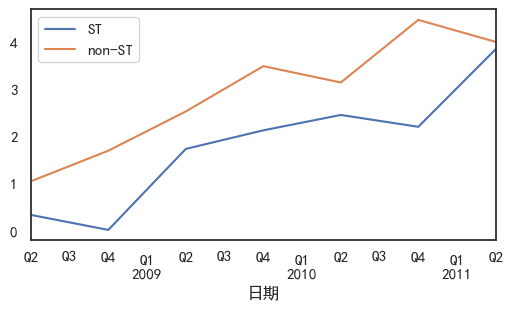

In [2]:
# result = {"ST": [], "non-ST": []}
# for company in dd:
#     if "ST" in company:
#         result["ST"].append(dd[company])
#     else:
#         result["non-ST"].append(dd[company])
# result = {i: pd.DataFrame(result[i]) for i in result}
# pd.DataFrame({i: result[i].mean() for i in result}).plot()
default_line = dd.copy()
for i in default_line:
    if (s := model.label[i]) in st_stocks["name"]:
        default_line[i] = (default_line[i].index >= st_stocks["date"][s]) & (
            default_line[i].index < st_stocks["enddate"][s]
        )
    else:
        default_line[i] = False
result = {"ST": dd[default_line].T, "non-ST": dd[~default_line].T}
pd.DataFrame({i: result[i].mean(axis=0) for i in result}).plot()

In [3]:
ks_test = {}
for date in result["ST"].columns:
    ks_test[date] = {
        "statistic": (
            tmp := stats.ks_2samp(
                result["ST"][date].dropna(),
                result["non-ST"][date].dropna(),
                method="asymp",
                alternative="greater",
            )
        ).statistic,
        "pvalue": tmp.pvalue,
    }
ks_test = pd.DataFrame(ks_test)
with open(project_root / "results/ks_test.tex", "w") as f:
    f.write(ks_test.to_latex())
ks_test

/var/folders/nd/_3lfc6dn11q3hd0b4cz17ypw0000gn/T/ipykernel_6225/1239703784.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(ks_test.to_latex())


,2008-06-30,2008-12-31,2009-06-30,2009-12-31,2010-06-30,2010-12-31,2011-06-30
statistic,0.326667,0.802632,0.378947,0.697368,0.253333,0.460000,0.293333
pvalue,0.241814,0.001343,0.198772,0.006367,0.408818,0.068529,0.311583


In [4]:
mw_test = {}
for date in result["ST"].columns:
    mw_test[date] = {
        "statistic": (
            tmp := stats.mannwhitneyu(
                result["ST"][date].dropna(),
                result["non-ST"][date].dropna(),
                method="asymptotic",
            )
        ).statistic,
        "pvalue": tmp.pvalue,
    }
mw_test = pd.DataFrame(mw_test)
with open(project_root / "results/mw_test.tex", "w") as f:
    f.write(mw_test.to_latex())
mw_test

/var/folders/nd/_3lfc6dn11q3hd0b4cz17ypw0000gn/T/ipykernel_6225/775700905.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(mw_test.to_latex())


,2008-06-30,2008-12-31,2009-06-30,2009-12-31,2010-06-30,2010-12-31,2011-06-30
statistic,158.000000,47.000000,135.000000,78.000000,182.000000,131.000000,217.000000
pvalue,0.230442,0.005167,0.284836,0.028662,0.443427,0.091772,0.892414


In [5]:
with pd.ExcelFile(project_root / "data/KMV模型已知量汇总.xlsx") as f:
    assets = Dataloader("assets", f).data.T
assets = assets[assets.index.isin(dd.columns)]
pearsons = {}
for date in dd.T:
    pearsons[date] = {
        "pearsonr": (tmp := stats.pearsonr(dd.T[date], assets[date]))[0],
        "pvalue": tmp[1],
    }
pearsons = pd.DataFrame(pearsons)
with open(project_root / "results/pearsons.tex", "w") as f:
    f.write(pearsons.to_latex())
pearsons

/var/folders/nd/_3lfc6dn11q3hd0b4cz17ypw0000gn/T/ipykernel_6225/43613031.py:12: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(pearsons.to_latex())


,2008-06-30,2008-12-31,2009-06-30,2009-12-31,2010-06-30,2010-12-31,2011-06-30
pearsonr,-0.265334,-0.221167,-0.410335,-0.230768,-0.354095,-0.444828,-0.464128
pvalue,0.016667,0.047233,0.000142,0.038201,0.001182,0.000032,0.000013


In [6]:
volatility = Volatility().data
volatility = volatility[dd.columns]
pearsons_vol = {}
for date in dd.T:
    pearsons_vol[date] = {
        "pearsonr": (tmp := stats.pearsonr(dd.T[date], volatility.T[date]))[0],
        "pvalue": tmp[1],
    }
pearsons_vol = pd.DataFrame(pearsons_vol)
with open(project_root / "results/pearsons_vol.tex", "w") as f:
    f.write(pearsons_vol.to_latex())
pearsons_vol

/var/folders/nd/_3lfc6dn11q3hd0b4cz17ypw0000gn/T/ipykernel_6225/917214607.py:11: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(pearsons_vol.to_latex())


,2008-06-30,2008-12-31,2009-06-30,2009-12-31,2010-06-30,2010-12-31,2011-06-30
pearsonr,-0.023419,-0.312969,-0.254424,-0.184716,-0.249410,-0.121688,-0.327771
pvalue,0.835603,0.004444,0.021901,0.098770,0.024741,0.279166,0.002817


## 违约距离对信贷风险的预测效果分析

论文中有错误，不是 2010-11 年成为 ST 的股票，而是 2007-08 年 ST 的股票


In [7]:
st_companies = "000008.SZ 000605.SZ 600139.SH 600466.SH 600706.SH 600714.SH 600988.SH 600793.SH 600421.SH 600610.SH".split()
st_date = st[st["stock"].isin(st_companies)]
st_date

,stock,name,date,enddate
10,000008.SZ,*ST宝投,2007-03-30,2011-12-31
14,600610.SH,S*ST中纺,2007-05-08,2011-12-31
75,600706.SH,*ST长信,2007-04-25,2011-12-31
80,600714.SH,*ST金瑞,2007-03-27,2010-12-31
101,000605.SZ,*ST四环,2007-04-30,2011-12-31
131,600793.SH,*ST宜纸,2008-02-01,2011-12-31
172,600139.SH,*ST绵高,2007-04-11,2008-12-31
242,600466.SH,*ST迪康,2007-05-08,2008-12-31
273,600988.SH,*ST宝龙,2007-04-27,2011-12-31
274,600421.SH,ST国药,2008-05-05,2011-12-31


In [8]:
st_companies = st[
    (st["date"] > "2010-06-30") & (st["stock"].isin(model.label.values()))
]
st_companies

,stock,name,date,enddate
279,002113.SZ,ST天润,2010-10-20,2011-12-31
281,002200.SZ,*ST大地,2011-05-04,2011-12-31


In [9]:
st_stock_dd = {}
for stock in st_companies.to_dict("records"):
    stock_name = [i for i in model.label if model.label[i] == stock["stock"]][0]
    st_stock_series = dd[stock_name].sort_index()

    st_stock_dd[stock_name] = pd.concat(
        [
            st_stock_series[st_stock_series.index < stock["date"]].tail(4),
            # .reset_index(drop=True),
            st_stock_series[st_stock_series.index > stock["date"]].head(1)
            # .reset_index(drop=True),
        ],
        ignore_index=True,
    )
st_stock_dd = pd.DataFrame(st_stock_dd)
st_stock_dd.index = ["ST前两年", "ST前一年半", "ST前一年", "ST前半年", "ST当年"]
st_stock_dd

,ST天润,*ST云投
ST前两年,0.238944,2.106469
ST前一年半,1.547428,4.392480
ST前一年,1.779768,3.959906
ST前半年,2.275831,2.631978
ST当年,1.222579,1.927210


<AxesSubplot: >

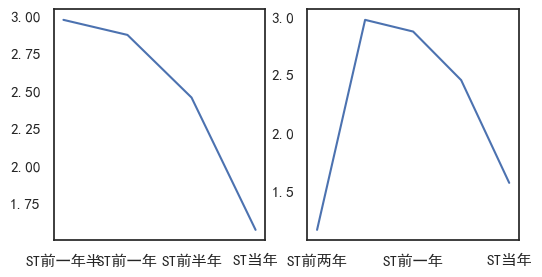

In [10]:
fig, axes = plt.subplots(1, 2)
st_stock_dd.mean(axis=1).tail(4).plot(ax=axes[0])
st_stock_dd.mean(axis=1).plot(ax=axes[1])

<AxesSubplot: >

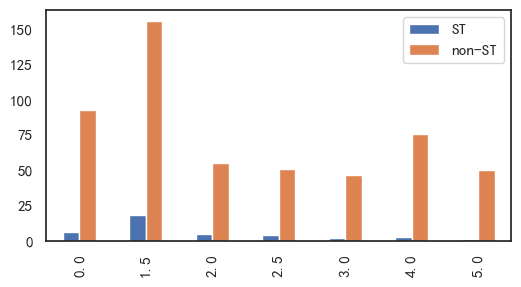

In [11]:
def grade(x, lst):
    if not lst:
        return 0
    assert min(lst) > 0
    if x > lst[0]:
        return grade(x, lst[1:])
    return lst[0]


result = {"ST": [], "non-ST": []}
for stock in dd.columns:
    result["ST"] = dd[default_line]
    result["non-ST"] = dd[~default_line]
temp = result["ST"].values
result["ST"] = temp[~np.isnan(temp)]
temp = result["non-ST"].values
result["non-ST"] = temp[~np.isnan(temp)]

res = pd.DataFrame(
    {
        j: pd.Series(
            [grade(i, [1.5, 2, 2.5, 3, 4, 5]) for i in result[j]]
        ).value_counts()
        for j in result
    }
)
res.plot.bar()

<AxesSubplot: >

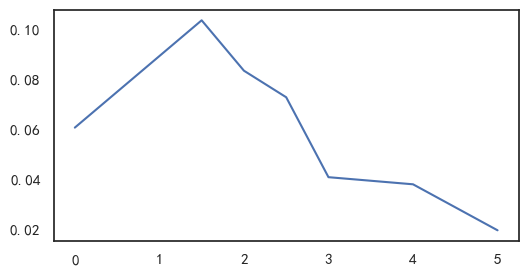

In [12]:
(res["ST"] / res.sum(axis=1)).plot()

|            | $H_0$为真  | $H_0$为假 |
| ---------- | ---------- | --------- |
| 拒绝$H_0   | $\alpha$   | $1-\beta$ |
| 不拒绝$H_0 | $1-\alpha$ | $\beta$   |


In [13]:
default_line_1 = dd.mean(axis=1) * 0.5 + 1.5 + 0.3
default_line_2 = dd.mean(axis=1) * 0.5 + 1.5  # - 0.3
negative_1 = dd.apply(lambda x: (x - default_line_1)) > 0
positive_2 = dd.apply(lambda x: (x - default_line_2)) < 0
alpha = (negative_1 & default_line).sum(axis=1) / default_line.sum(axis=1)
beta = (positive_2 & (~default_line)).sum(axis=1) / (~default_line).sum(axis=1)
last_table = pd.DataFrame({"alpha": alpha, "beta": beta})
with open(project_root / "results/table_11.tex", "w") as f:
    f.write(last_table.to_latex())
last_table

/var/folders/nd/_3lfc6dn11q3hd0b4cz17ypw0000gn/T/ipykernel_6225/2757599155.py:9: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(last_table.to_latex())


,alpha,beta
日期,,
2008-06-30,0.000000,0.800000
2008-12-31,0.000000,0.723684
2009-06-30,0.200000,0.631579
2009-12-31,0.000000,0.539474
2010-06-30,0.333333,0.560000
2010-12-31,0.333333,0.386667
2011-06-30,0.666667,0.506667
